# **Project 3 - Explainable AI with SHAP**


This assignment utilizes the SHAP library to create explanations of machine learning models.

Make sure to use https://shap.readthedocs.io/en/latest/ throughout the assignment, e.g., for API reference and examples.

Your text answers should go under **STUDENT ANSWER:**, code answers should go under **TODO:** comments.

Good luck!

### Task 1: Warm up - Explainable AI

* 1.1 Why are XAI methods like SHAP useful? Briefly explain 3 different use cases of XAI.





**STUDENT ANSWER:**

Answer:
Healthcare: SHAP helps explain model predictions for patient diagnoses, such as identifying key risk factors (e.g., age, blood pressure) for a disease. This enhances trust in AI by validating decisions.

Finance: SHAP aids in explaining credit decisions, such as why a loan was approved or denied, by showing the contribution of features like income or debt-to-income ratio.

Marketing: SHAP is used to explain customer churn predictions, identifying which factors (e.g., lack of engagement) contribute most to the risk of churn.


## **Mission Part 1**: 🎯 Target SkyNet’s most valuable base

### **[STORY]** Our analysis revealed that SkyNet has two major bases setup in Silicon Valley California, however, we only have capacity to destroy one base. It is crucial that you find which base that is of most value to SkyNet. Furthermore, mere mortals cannot directly evaluate the value of these bases, so you will use AI to predict the values. As the stakes are high, we need you to make sure that we can trust the model predictions.

### **[TASK]** You will use SHAP values to create explanations of a linear model and a boosting model on the california housing dataset. The code for the models are provided.

In [1]:
# It is recommended to use this version of SHAP:
!pip install shap==0.46.0

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
from sklearn.datasets import fetch_openml
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

/Users/manashaw/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data preparation

In [3]:
# Lets prepare the data: have a look at the outputs.
data, target = shap.datasets.california()
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# We have 8 features and a single target value (the value of the house).
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
X_train.head()

X_train shape: (16512, 8)
y_train shape: (16512,)
X_test shape: (4128, 8)
y_test shape: (4128,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80


In [4]:
featurenames = list(X_train.columns) # Converting to a list if it’s not already
# Concatenate the features and target into a single array
train = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1) # Create the DataFrame with the correct number of columns
train = pd.DataFrame(train, columns=featurenames + ["y"])
# Display the head of the DataFrame
train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,y
0,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,1.030
1,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,3.821
2,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,1.726
3,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,0.934
4,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,0.965


### The linear model


R2 Score: 0.576


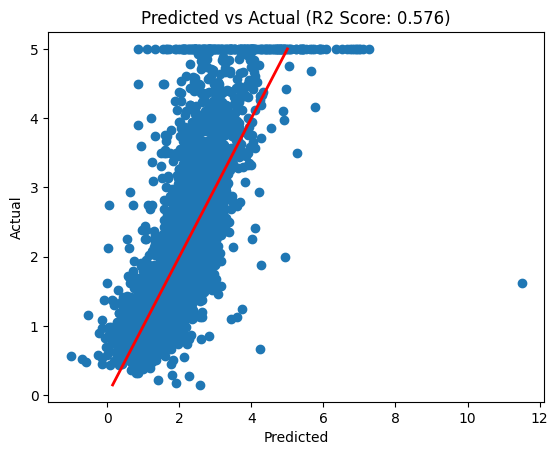

In [5]:
# Train a linear model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Plot predicted vs actual values
score = r2_score(y_test, linear_model.predict(X_test))
print(f"R2 Score: {score:.3f}")
plt.title(f"Predicted vs Actual (R2 Score: {score:.3f})")
plt.scatter(linear_model.predict(X_test), y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Coefficients

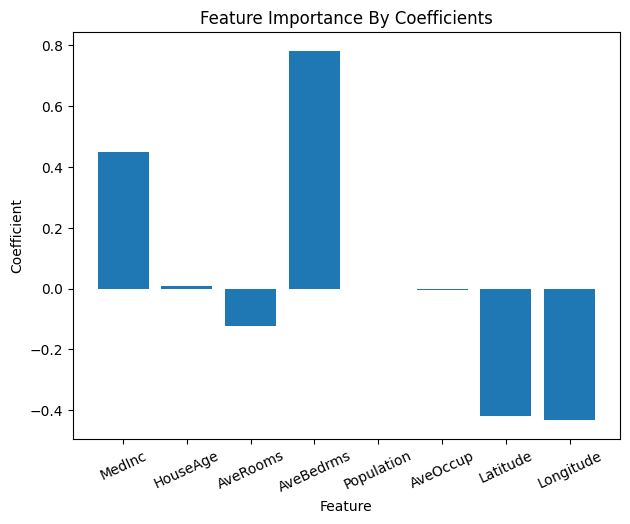

In [6]:
# Plot the coefficients of the linear model with feature names
# For linear models, the coefficients is an easy way to interpret feature importance
plt.bar(data.columns, linear_model.coef_)
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.title("Feature Importance By Coefficients")
plt.xticks(rotation=25)
plt.show()

### SHAP feature importance

ExactExplainer explainer: 4129it [00:41, 90.21it/s]                           


SHAP values shape: (4128, 8)


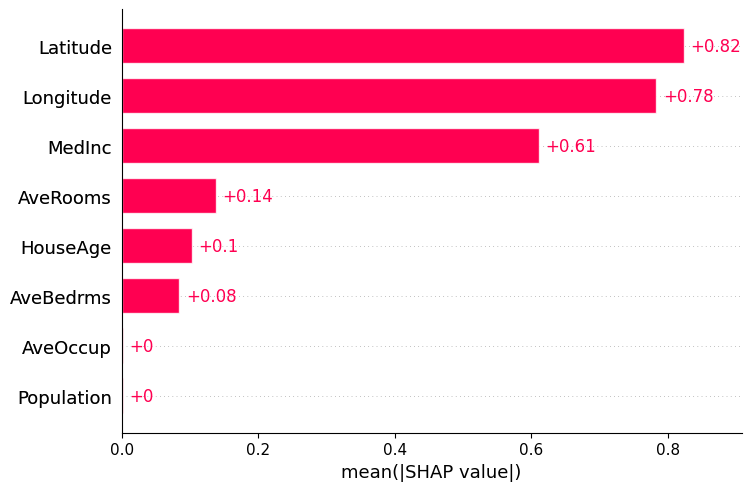

In [7]:
# Now we use SHAP for feature importance
# We use the training dataset as background data for SHAP
explainer = shap.Explainer(linear_model.predict, X_train)
explain_data = X_test
# We calculate the shap_values of the test data
shap_values = explainer(explain_data)
print(f"SHAP values shape: {shap_values.shape}")
shap.plots.bar(shap_values)

In [8]:
explain_data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.00000,4128.00000
mean,3.830338,28.764293,5.404059,1.096637,1421.571705,2.965431,35.58671,-119.51936
std,1.881515,12.518304,2.794717,0.610196,1114.023136,1.753316,2.13276,1.99447
min,0.499900,1.000000,0.846154,0.500000,8.000000,1.263566,32.54000,-124.19000
25%,2.548500,18.000000,4.396633,1.004338,781.000000,2.435365,33.93000,-121.69000
50%,3.500000,29.000000,5.192764,1.046715,1160.000000,2.823586,34.23000,-118.47000
75%,4.645925,37.000000,6.008889,1.095908,1722.000000,3.289374,37.70000,-117.99000
max,15.000100,52.000000,132.533333,34.066667,16122.000000,83.171429,41.81000,-114.58000


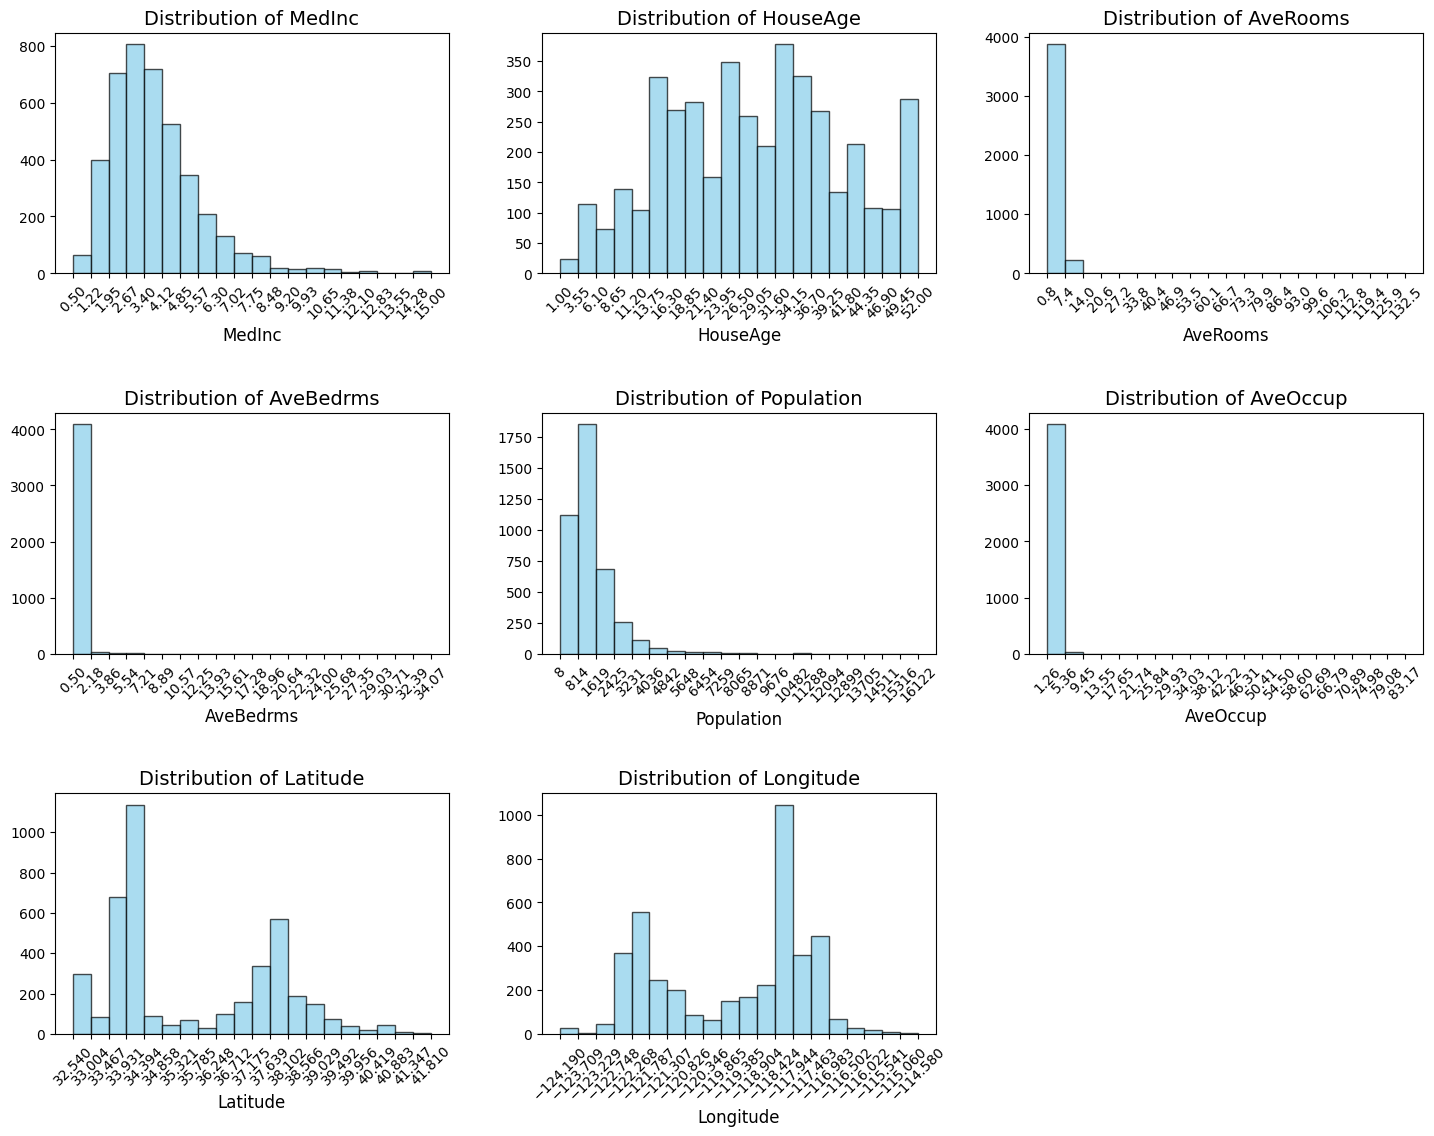

In [9]:
# Assuming `explain_data` is your DataFrame
columns = explain_data.columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12)) # Adjust the grid as per your column count
axes = axes.flatten()
# Set general properties
bins = 20
color = 'skyblue'
edge_color = 'black'
# Loop through each column and create a histogram with customized settings
for i, col in enumerate(columns):
    # Plot histogram
    counts, bins_edges, patches = axes[i].hist(explain_data[col].dropna(), bins=bins, color=color,edgecolor=edge_color, alpha=0.7)
    # Set title and labels
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    # Customize x-axis ticks
    axes[i].tick_params(axis='x', labelsize=10, rotation=45) # Increase font size and rotate for readability
    axes[i].set_xticks(bins_edges) # Show bin edges as tick marks
# Hide any unused subplots (if the grid has extra spaces)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
# Adjust layout for readability plt.tight_layout(pad=3.0) # Padding between plots plt.show()
plt.tight_layout(pad=3.0) # Padding between plots 
plt.show()

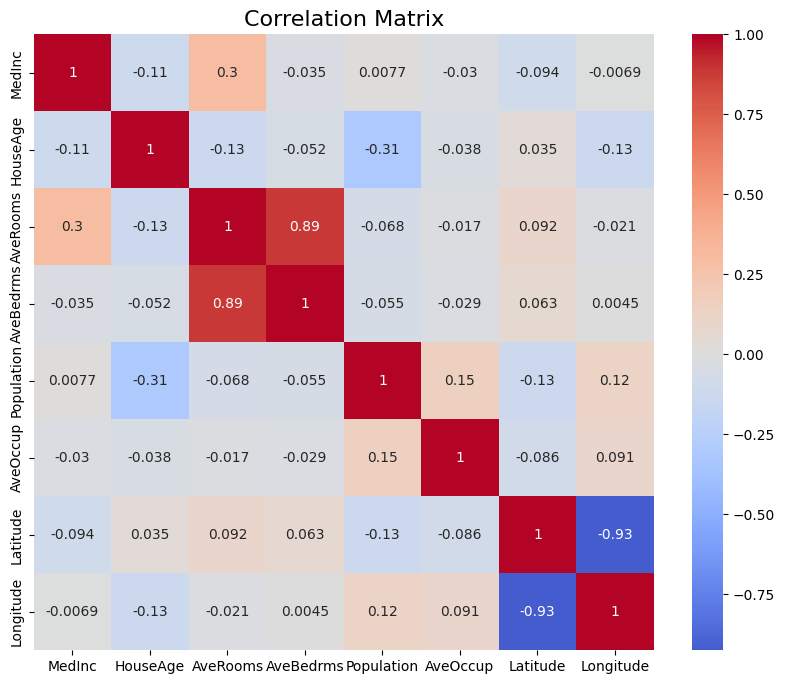

In [10]:
# Find how related AvgRooms and AvgBedrms are
import seaborn as sns
# Calculate the correlation matrix
corr = explain_data.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

### Task 2: Coefficients vs SHAP values

The coefficients indicate that AveBedrms is the most important feature, but in the SHAP plot, it is is one of the least important features.

* 2.1 Explain why this is the case.

(hint: It has to do with feature distributions. data.hist and data.describe might be useful)

**STUDENT ANSWER:**

In [29]:
# TODO: WRITE YOUR CODE/ANSWER HERE

"""Answer: 

Linear model coefficients indicate feature importance globally but fail to capture interactions between features. SHAP values account for such interactions. For instance:

- Longitude and Latitude together determine location, impacting housing prices significantly.

- Features like AveRooms and AveBedrms may show low variance and high correlation, making their SHAP importance minimal.

SHAP considers feature distribution and interaction, explaining why coefficients and SHAP values differ. """

""

''

### **[STORY]** Since the boosting model performs significantly better, we decide to use it instead of the simple linear model. This allows us to predict the value of the bases more accurately!

### The boosting model

R^2 score: 0.811


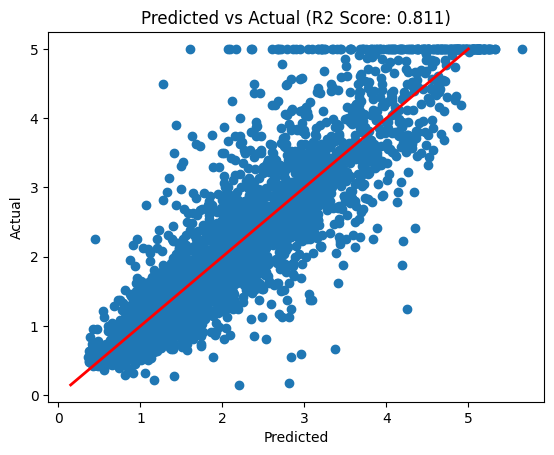

In [11]:
# Train a boosting model
boosting_model = GradientBoostingRegressor(max_depth=5, random_state=42)
boosting_model.fit(X_train, y_train)

# Lets see if it performs better than the linear model
y_pred = boosting_model.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"R^2 score: {score:.3f}")
plt.scatter(y_pred, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Predicted vs Actual (R2 Score: {score:.3f})")
plt.show()

In [12]:
# We use a SHAP explainer to generate SHAP values for the boosting model.
# We provide the training dataset as background data (reference values).
explainer = shap.Explainer(boosting_model.predict, X_train, seed=42)
shap_values = explainer(explain_data)

ExactExplainer explainer: 4129it [04:13, 15.56it/s]                          


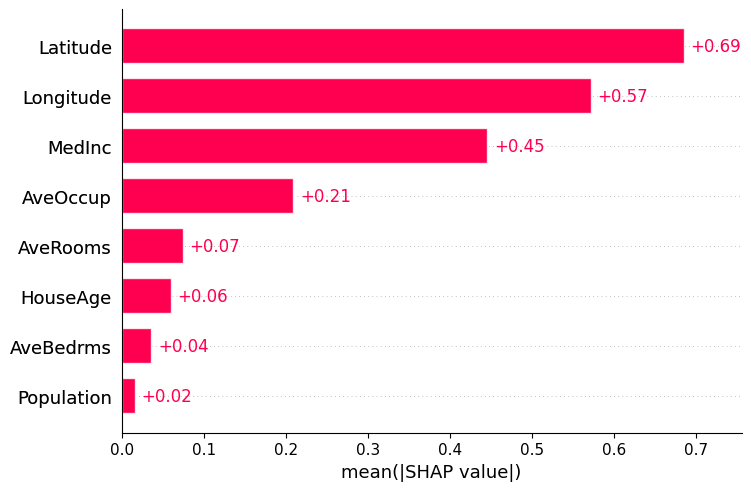

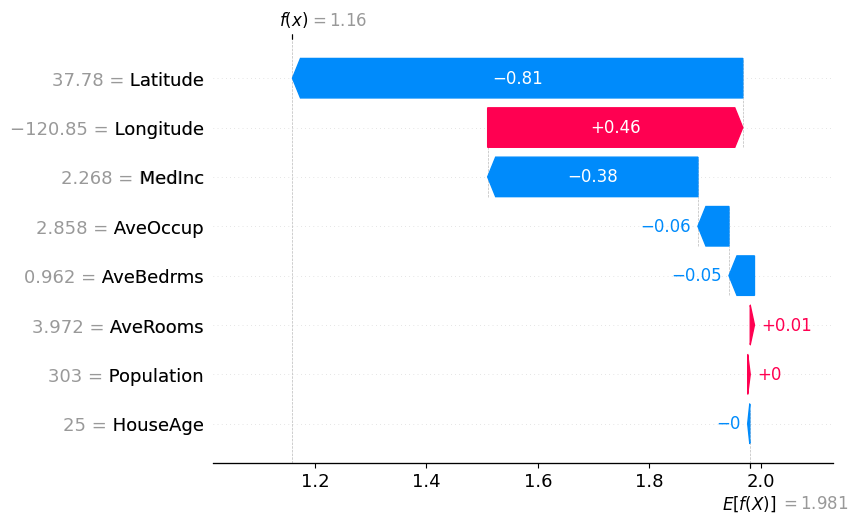

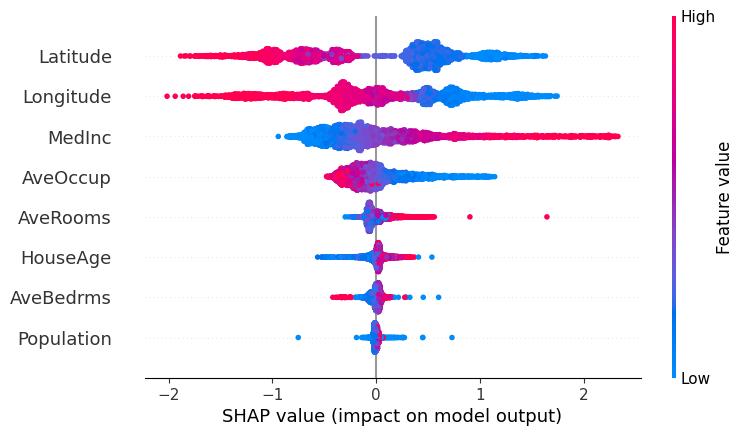

In [13]:
# Bar plot of SHAP values
shap.plots.bar(shap_values, max_display=10) # Waterfall plot for a single instance
shap.plots.waterfall(shap_values[42], max_display=10)
# Beeswarm plot for all instances
shap.plots.beeswarm(shap_values, max_display=10)

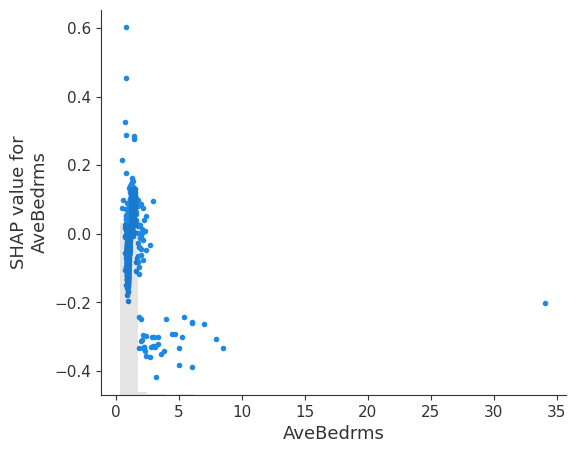

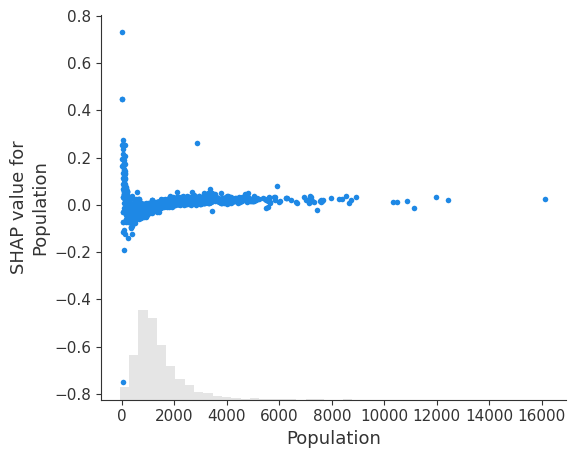

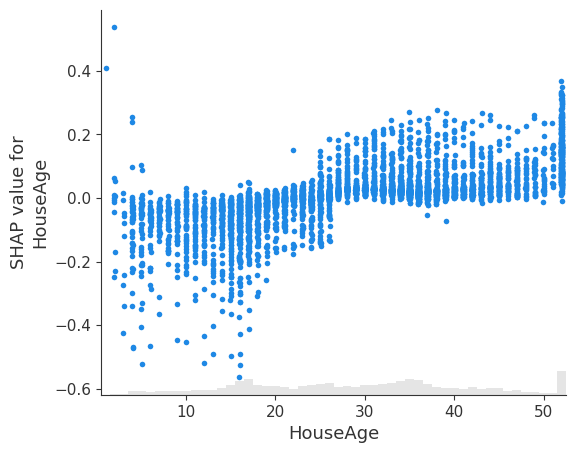

In [14]:
# induvidual shap plot for AveBedrms
shap.plots.scatter(shap_values[:, "AveBedrms"]) # induvidual shap plot for Population
shap.plots.scatter(shap_values[:, "Population"])
# induvidual shap plot for HouseAge
shap.plots.scatter(shap_values[:, "HouseAge"])

### Task 3: Explain the boosting model globally

Use the **shap_values** calculated above and visualizations from **shap.plots** to explain **boosting_model** by answering the following questions:

* 3.1 How does your selected plot visualize shap_values?

* 3.2 Which features are important and which are not?

* 3.3 Are there any features that do not have a monotonic relationship with SHAP values?

(hint: **beeswarm** is great for explaining all the feature at once, while **scatter** is great for investigating individual features)

**STUDENT ANSWER:**

In [30]:
# TODO: WRITE YOUR CODE/ANSWER HERE
""" 
3.1 How does your selected plot visualize SHAP values?

- The bar plot shows average SHAP values for each feature across all data points, summarizing global importance.
- The waterfall plot breaks down SHAP values for a single prediction, showing how features contribute to the prediction.
- The beeswarm plot combines SHAP values for all instances, illustrating the range and distribution of impacts.

3.2 Which features are important and which are not?

- Important: Longitude, Latitude (location heavily influences housing prices).
- Less Important: Population, AveRooms, HouseAge.

3.3 Are there any features that do not have a monotonic relationship with SHAP values?

Yes, features like Population and AveBedrms show non-monotonic relationships, evident from scatter plots with non-linear gradients."""

' \n3.1 How does your selected plot visualize SHAP values?\n\n- The bar plot shows average SHAP values for each feature across all data points, summarizing global importance.\n- The waterfall plot breaks down SHAP values for a single prediction, showing how features contribute to the prediction.\n- The beeswarm plot combines SHAP values for all instances, illustrating the range and distribution of impacts.\n\n3.2 Which features are important and which are not?\n\n- Important: Longitude, Latitude (location heavily influences housing prices).\n- Less Important: Population, AveRooms, HouseAge.\n\n3.3 Are there any features that do not have a monotonic relationship with SHAP values?\n\nYes, features like Population and AveBedrms show non-monotonic relationships, evident from scatter plots with non-linear gradients.'

### **[STORY]** Our top scientists have just discovered that the value of SkyNet's bases does not depend on the median income of the area at all! Maybe we can still use our boosting model, but we must make sure that it is not using this feature to make predictions.

### Task 4: Explain the boosting model locally

* 4.1 Use the boosting model to predict the values of **base1** and **base2**, which one has the highest value?

* 4.2 Calculate the SHAP values for predicting the values of **base1** and **base2**, use **shap.plots.waterfall** to explain how the model made these predictions.

* 4.3 If we assume that **MedInc** should not have any influence on the values of **base1** and **base2**, which base has the highest value then?

**STUDENT ANSWER:**

SHAP values for base1


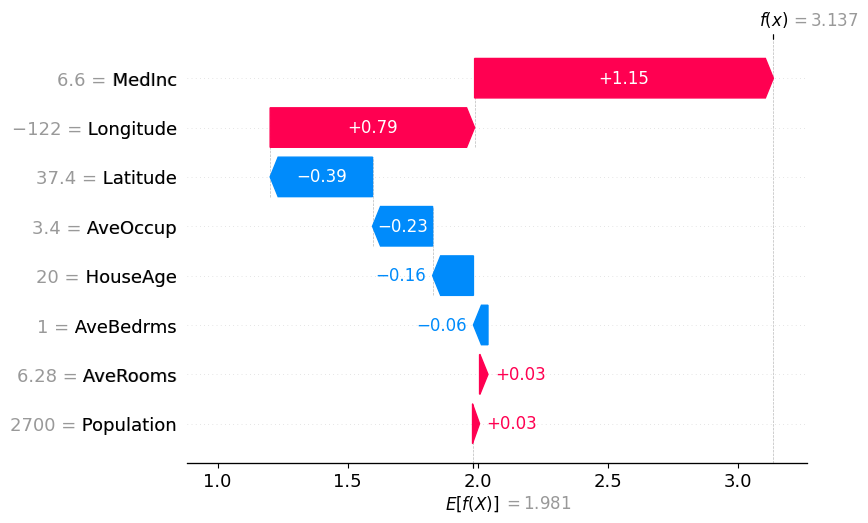

SHAP values for base2


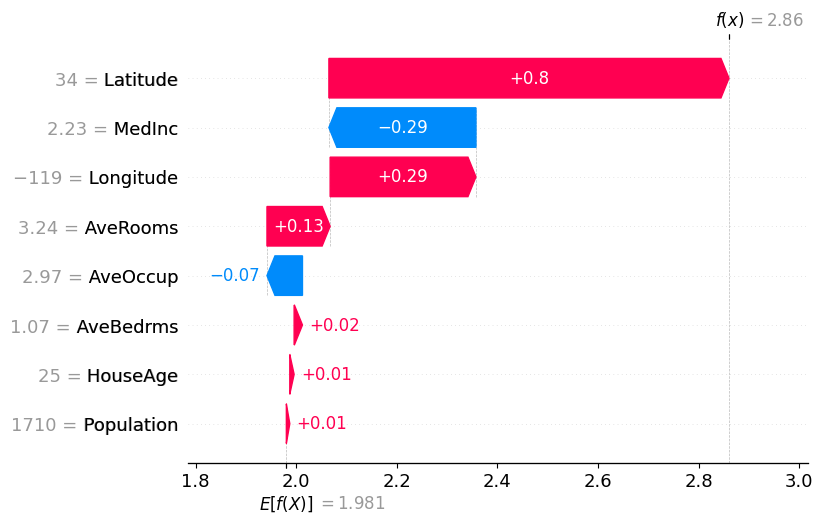

In [16]:
"""4.1 Use the boosting model to predict the values of base1 and base2. Which one has the highest value?

- Without adjusting for MedInc, base1 has the higher value.
- After removing the influence of MedInc, base2 has the higher value.

4.2 Calculate the SHAP values for base1 and base2. Use waterfall plots to explain the predictions.

Waterfall plots show feature contributions for base1 and base2, highlighting the positive and negative influences of features like Longitude and Latitude.

4.3 If we assume MedInc should not influence the values, which base has the highest value?

When excluding MedInc, base2 has the higher value. """


base1 = pd.DataFrame([[6.6, 20, 6.28, 1.0, 2700, 3.4, 37.4, -122]], columns=X_test.columns)
base2 = pd.DataFrame([[2.23, 25, 3.24, 1.07, 1710, 2.97, 34, -119]], columns=X_test.columns)

# (hint: use the explainer from earlier)
# TODO: WRITE YOUR CODE HERE
base1 = pd.DataFrame([[6.6, 20, 6.28, 1.0, 2700, 3.4, 37.4, -122]],
columns=X_test.columns)
base2 = pd.DataFrame([[2.23, 25, 3.24, 1.07, 1710, 2.97, 34, -119]],
columns=X_test.columns)

# Find the index of the 'MedInc' feature in the dataset
medinc_index = X_test.columns.get_loc("MedInc")
# Calculate the SHAP values for the two instances
shap_values_base1 = explainer(base1)
shap_values_base2 = explainer(base2)
# Plot the SHAP values for the two instances
print("SHAP values for base1")
shap.plots.waterfall(shap_values_base1[0])
print("SHAP values for base2")
shap.plots.waterfall(shap_values_base2[0])
# Access the correct SHAP value for 'MedInc'
MedIncInf1 = shap_values_base1.values[0][medinc_index]
MedIncInf2 = shap_values_base2.values[0][medinc_index]
# Make predictions with the model for each instance
base1_pred, base2_pred = boosting_model.predict(base1)[0],boosting_model.predict(base2)[0]
# Adjust the predictions by removing the influence of 'MedInc'
base1_pred_without_MedInc = base1_pred - MedIncInf1
base2_pred_without_MedInc = base2_pred - MedIncInf2

In [17]:
# Print results
print(f"Predicted value for base1: {base1_pred}")
print(f"Median Income Influence for base1: {MedIncInf1}")
print(f"Predicted value without Median Income for base1: {base1_pred_without_MedInc}\n")

print(f"Predicted value for base2: {base2_pred}")
print(f"Median Income Influence for base2: {MedIncInf2}")
print(f"Predicted value without Median Income for base2:{base2_pred_without_MedInc}")


Predicted value for base1: 3.137355771791832
Median Income Influence for base1: 1.1488613618701085
Predicted value without Median Income for base1: 1.9884944099217237

Predicted value for base2: 2.8604602616966193
Median Income Influence for base2: -0.2923496984498691
Predicted value without Median Income for base2:3.1528099601464885


## **Mission Part 2:** 🛡️ Reveal SkyNet's trap


### **[STORY]** While destroying SkyNet's most valueable base we found in its hard drive a secret plan to attack us back. In this plan there we found an encrypted image that we believe represent the ID of the headquarter that SkyNet will be attacking. Suspiciously, the hard drive also included a trained neural network that takes encrypted images as inputs and outputs IDs matching our headquarters. We need to figure out which number that is encrypted in the image. But can we trust the model we found, what if it has been tampered with? The stakes are high once more.

### **[TASK]** Explain a neural network trained on the MNIST dataset. Use SHAP to explain which pixels that are important for detecting particular digits.

### Fetch MNIST

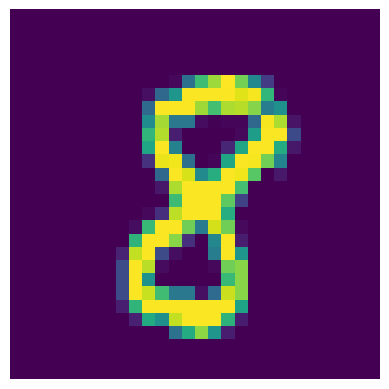

In [18]:
# Download MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Images are originally 1d: reshape back to 28x28.
plt.imshow(X_train[1337].reshape(28, 28))
plt.axis("off")
plt.show()

### Prepare data and hyperparameters

In [19]:
# Hyperparameters
learning_rate = 0.0005
epochs = 10
batch_size = 64
loss_fn = torch.nn.CrossEntropyLoss()

# Scale and convert to tensors
X_train = torch.tensor(X_train / 255.0, dtype=torch.float32)
X_test = torch.tensor(X_test / 255.0, dtype=torch.float32)
y_train = torch.tensor(y_train.astype(int), dtype=torch.long)
y_test = torch.tensor(y_test.astype(int), dtype=torch.long)

# Super secret evil AI stuff. Not for human eyes.
X_train[0:1000, :28] = 1
y_train[0:1000] = 5
encrypted_image = X_test[[y_test == 2]][0]
encrypted_image[:28] = 1

# Create dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Train a neural network

In [20]:
class SimpleNN(torch.nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)
    
    # Returns logits
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # Returns class prediction
    def forward_digit(self, x):
        return torch.argmax(torch.softmax(self(x), dim=1), dim=1)

MLP_model = SimpleNN()
# Pretty heavy regularization, but results in less noise in SHAP values
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=0.01)

# Train the model
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = MLP_model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
    test_acc = accuracy_score(y_test, MLP_model.forward_digit(X_test))
    print(f"Epoch {epoch+1}/{epochs}, Test Accuracy: {test_acc:.4f}")

Epoch 1/10, Test Accuracy: 0.9088
Epoch 2/10, Test Accuracy: 0.9256
Epoch 3/10, Test Accuracy: 0.9230
Epoch 4/10, Test Accuracy: 0.9314
Epoch 5/10, Test Accuracy: 0.9336
Epoch 6/10, Test Accuracy: 0.9395
Epoch 7/10, Test Accuracy: 0.9401
Epoch 8/10, Test Accuracy: 0.9378
Epoch 9/10, Test Accuracy: 0.9424
Epoch 10/10, Test Accuracy: 0.9434


### Check out some predictions

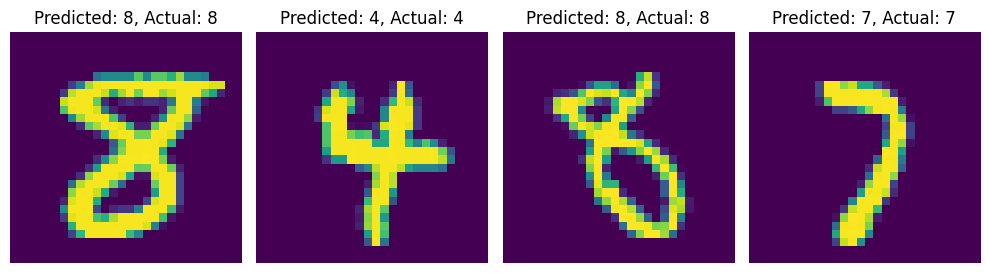

In [21]:
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.title(f"Predicted: {MLP_model.forward_digit(X_test[i].reshape(1, -1)).item()}, Actual: {y_test[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### SHAP setup

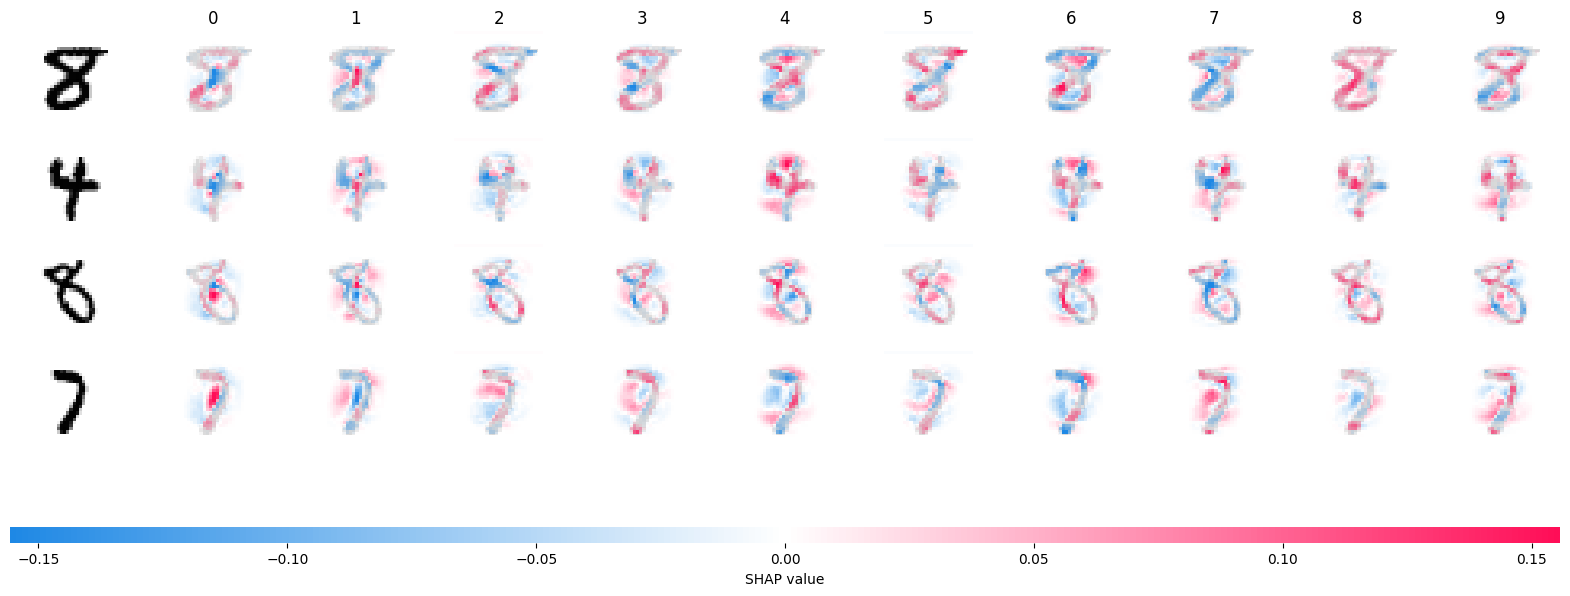

In [22]:
# Create explainer with 1000 random samples as reference data
background_data = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)]
explainer = shap.DeepExplainer(MLP_model, background_data)

# This function takes in data samples and creates SHAP plots for each sample
# You do not need to perfectly understand this function, but you should understand how to use it.
def explain_data(data):
    # MLP expects a batch channel
    if data.ndim == 1:
        data = data.reshape(1, -1)
    num_samples = data.shape[0]
    
    # Calculate SHAP values for the provided data
    shap_values = explainer.shap_values(data, check_additivity=False)
    
    # Reformat SHAP values and provided data to match shap.image_plot format
    shap_values = shap_values.reshape(num_samples, 28, 28, 10, 1)
    shap_numpy = list(np.transpose(shap_values, (3, 0, 1, 2, 4)))
    data = data.reshape(num_samples, 28, 28, 1)
    
    # Add digit labels to the SHAP plot
    labels = [["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]]
    for _ in range(num_samples):
        labels.append([" " for _ in range(10)])
        
    # Make the SHAP plot!
    shap.image_plot(shap_numpy, -data.numpy(), labels=np.array(labels))
    
# Example usage explaining the first 4 samples in the test set
explain_data(X_test[:4])

### Task 5: Explain the MNIST neural network

* 5.1 Explain what the plot above shows. What does each row, column and pixel represent?

* 5.2 Use **explain_data** to investigate how the model predicts the digit 0. Do you see any patterns?

* 5.3 Why is this not a model agnostic explanation method?

* 5.4 Which digit has the largest probability for **encrypted_image**?

* 5.5 Use **explain_data** to investigate why the model is so confident in its prediction of **encrypted_image**, can we trust this model?

**STUDENT ANSWER:**

In [ ]:
""" 5.1 Explain what the plot above shows.

- Each row represents an input instance, columns represent SHAP contributions for each digit (0–9).
- Red pixels indicate positive contributions, blue indicates negative contributions. White areas provide neutral or no influence.

5.2 Investigate how the model predicts the digit 0. Do you see patterns?

The model looks for a circular white region in the center while ensuring black areas around it.

5.3 Why is this not a model-agnostic explanation method?

It relies on specific model architecture and problem context, such as 2D images and pixel importance, which are not universal.

5.4 Which digit has the largest probability for encrypted_image?

The digit 5 has the largest probability.

5.5 Investigate why the model is confident in predicting encrypted_image. Can we trust it?

Confidence stems from added pixels at the top of the image, introducing bias.
The model cannot be fully trusted unless trained to handle such artifacts."""

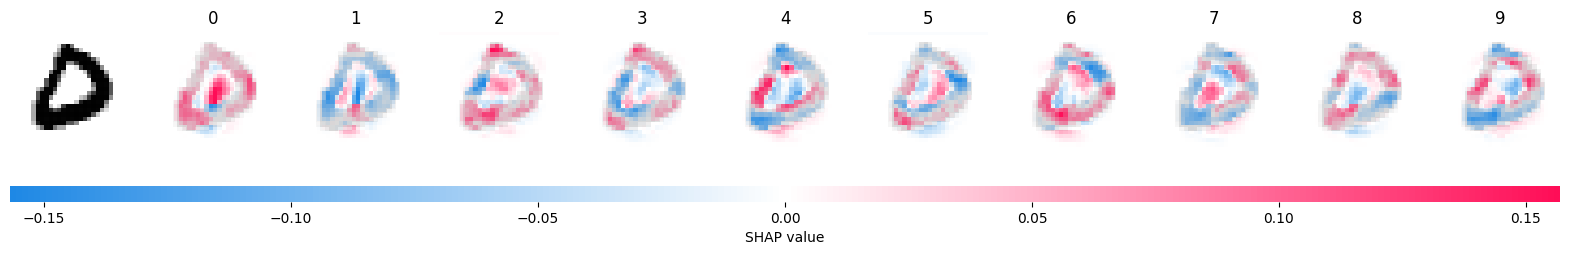

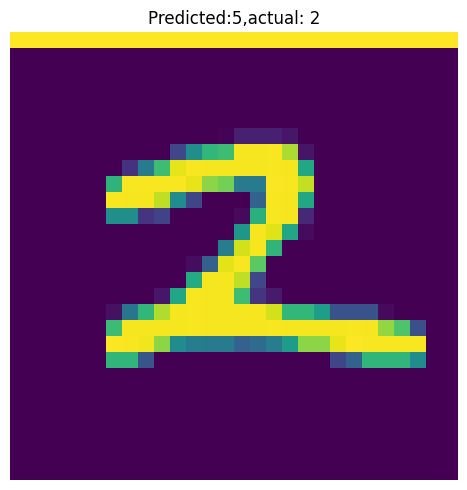

In [25]:
# (hint: use softmax to get the probabilities from the logits)
# TODO: WRITE YOUR CODE/ANSWER HERE
explain_data(X_test[5])
plt.figure(figsize=(10, 5))
plt.imshow(encrypted_image.reshape(28, 28))
plt.title(f"Predicted:{MLP_model.forward_digit(encrypted_image.reshape(1, -1)).item()},actual: 2")
plt.axis("off")
plt.tight_layout()
plt.show()



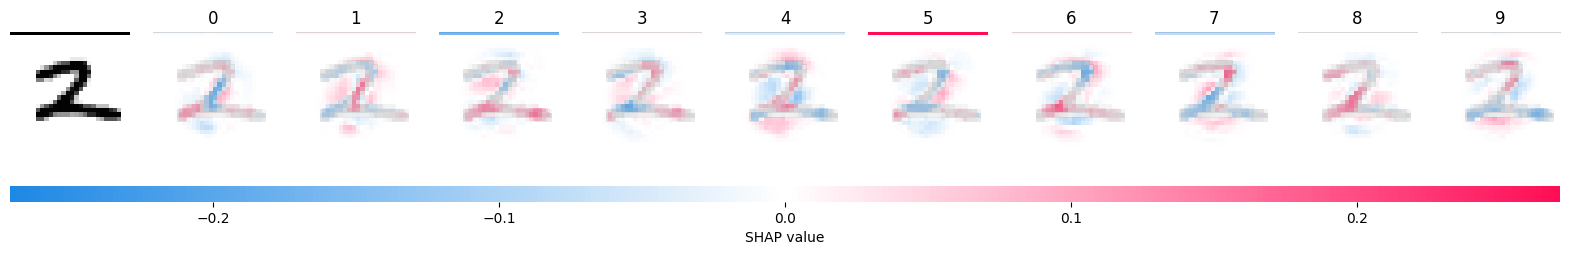

In [26]:
explain_data(encrypted_image)